In [6]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm

print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("SciPy:", scipy.__version__)
print("Statsmodels:", sm.__version__)


NumPy: 1.26.4
Pandas: 2.1.4
SciPy: 1.11.4
Statsmodels: 0.14.6


In [7]:
import pandas as pd

import numpy as np
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ardl_select_order, ARDL, UECM
import matplotlib.pyplot as plt


In [8]:
df3 = pd.read_csv('gdp-per-capita/gdp-per-capita.csv', skiprows=4)



df4 = pd.read_csv('co-emissions-per-capita.filtered/co-emissions-per-capita.csv')


# extract india gdp wide to long:
# Keep only India
india_gdp_pc = df3[df3['Country Name'] == 'India']

# india_gdp_pc.head()
# Drop metadata columns
india_gdp_pc = india_gdp_pc.drop(
    columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 69']
)

# Convert wide → long
india_gdp_pc = india_gdp_pc.melt(
    var_name='Year',
    value_name='GDP_pc'
)

# Clean year
india_gdp_pc['Year'] = india_gdp_pc['Year'].astype(int)

# Drop missing
india_gdp_pc = india_gdp_pc.dropna()


# clean co2 per capita 

india_co2_pc = df4[df4['Entity'] == 'India'][['Year', 'Annual CO₂ emissions (per capita)']]
india_co2_pc = india_co2_pc.rename(
    columns={'Annual CO₂ emissions (per capita)': 'CO2_pc'}
)

india_co2_pc.head()

# merge GDP and CO2 
ekc_pc_df = pd.merge(
    india_gdp_pc,
    india_co2_pc,
    on='Year',
    how='inner'
)

ekc_pc_df.shape
ekc_pc_df.head()



ekc_pc_df['ln_GDP_pc'] = np.log(ekc_pc_df['GDP_pc'])
ekc_pc_df['ln_CO2_pc'] = np.log(ekc_pc_df['CO2_pc'])

ekc_pc_df['ln_GDP_pc_sq'] = ekc_pc_df['ln_GDP_pc'] ** 2




In [9]:


df = ekc_pc_df.copy()   # use the final merged per-capita dataframe
df = df[['Year', 'ln_CO2_pc', 'ln_GDP_pc', 'ln_GDP_pc_sq']].dropna()
df = df.set_index('Year')


In [10]:
# ARDL allows I(0) and I(1), but not I(2).

def adf_test(series, name):
    result = adfuller(series, autolag='AIC')
    print(f"{name}: ADF p-value = {result[1]:.4f}")

adf_test(df['ln_CO2_pc'], 'ln_CO2_pc')
adf_test(df['ln_GDP_pc'], 'ln_GDP_pc')
adf_test(df['ln_GDP_pc_sq'], 'ln_GDP_pc_sq')


ln_CO2_pc: ADF p-value = 0.9865
ln_GDP_pc: ADF p-value = 0.9849
ln_GDP_pc_sq: ADF p-value = 0.9971


In [11]:
# Lag selection
# This answers: How much “memory” emissions and income really have.
sel = ardl_select_order(
    endog=df['ln_CO2_pc'],
    exog=df[['ln_GDP_pc', 'ln_GDP_pc_sq']],
    maxlag=3,
    maxorder=3,
    ic='aic'
)

print(sel.ar_lags)
print(sel.dl_lags)
print (sel._ics)
# print(sel.orders)
# print(sel.exog_lags)
# print(sel.model_orders)




[1]
{'ln_GDP_pc': [0, 1], 'ln_GDP_pc_sq': [0, 1]}
(((0,), (0, 0, 0)),)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [12]:
# ARDL model estimate 

ardl_model = sel.model.fit()
print(ardl_model.summary())



                              ARDL Model Results                              
Dep. Variable:              ln_CO2_pc   No. Observations:                   65
Model:                  ARDL(1, 1, 1)   Log Likelihood                 138.962
Method:               Conditional MLE   S.D. of innovations              0.028
Date:                Tue, 27 Jan 2026   AIC                           -263.925
Time:                        23:05:38   BIC                           -248.812
Sample:                             1   HQIC                          -257.971
                                   65                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.3610      0.203     -1.775      0.081      -0.768       0.046
ln_CO2_pc.L1        0.9338      0.031     30.455      0.000       0.872       0.995
ln_GDP_pc.L0       -0.5932      

In [13]:
# Does a long-run EKC relationship even exist?”

# Test joint significance of level terms
hypotheses = [
    'ln_CO2_pc.L1 = 0',
    'ln_GDP_pc.L1 = 0',
    'ln_GDP_pc_sq.L1 = 0'
]

f_test = ardl_model.f_test(hypotheses)
print(f_test)



<F test: F=340.5135060071891, p=8.976504971677844e-37, df_denom=58, df_num=3>


In [14]:
print(ardl_model.params.index)
ardl_model.params


Index(['const', 'ln_CO2_pc.L1', 'ln_GDP_pc.L0', 'ln_GDP_pc.L1',
       'ln_GDP_pc_sq.L0', 'ln_GDP_pc_sq.L1'],
      dtype='object')


const             -0.361025
ln_CO2_pc.L1       0.933827
ln_GDP_pc.L0      -0.593244
ln_GDP_pc.L1       0.677845
ln_GDP_pc_sq.L0    0.055857
ln_GDP_pc_sq.L1   -0.059674
dtype: float64

In [15]:
# long run GDP coefficients:
phi = ardl_model.params['ln_CO2_pc.L1']

beta_gdp_lr = (
    ardl_model.params['ln_GDP_pc.L0'] +
    ardl_model.params['ln_GDP_pc.L1']
) / (1 - phi)

beta_gdp2_lr = (
    ardl_model.params['ln_GDP_pc_sq.L0'] +
    ardl_model.params['ln_GDP_pc_sq.L1']
) / (1 - phi)

beta_gdp_lr, beta_gdp2_lr


(1.278469205237416, -0.057680284778516375)

In [16]:
# turning point:

turning_point = np.exp(-beta_gdp_lr / (2 * beta_gdp2_lr))
print("Long-run EKC turning point (GDP per capita):", turning_point)



Long-run EKC turning point (GDP per capita): 65015.17487259461


In [17]:
# error correction term:

# Long-run relationship (cointegrating equation)
ekc_pc_df['ECT'] = (
    ekc_pc_df['ln_CO2_pc']
    - beta_gdp_lr * ekc_pc_df['ln_GDP_pc']
    - beta_gdp2_lr * ekc_pc_df['ln_GDP_pc_sq']
)


In [18]:
# difference the variables

ekc_pc_df['d_ln_CO2_pc'] = ekc_pc_df['ln_CO2_pc'].diff()
ekc_pc_df['d_ln_GDP_pc'] = ekc_pc_df['ln_GDP_pc'].diff()
ekc_pc_df['d_ln_GDP_pc_sq'] = ekc_pc_df['ln_GDP_pc_sq'].diff()
ekc_pc_df['ECT_lag'] = ekc_pc_df['ECT'].shift(1)

ecm_df = ekc_pc_df.dropna()


In [19]:

X = sm.add_constant(ecm_df[
    ['d_ln_GDP_pc', 'd_ln_GDP_pc_sq', 'ECT_lag']
])
y = ecm_df['d_ln_CO2_pc']

ecm_model = sm.OLS(y, X).fit()
print(ecm_model.summary())


                            OLS Regression Results                            
Dep. Variable:            d_ln_CO2_pc   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     4.726
Date:                Tue, 27 Jan 2026   Prob (F-statistic):            0.00501
Time:                        23:05:38   Log-Likelihood:                 138.96
No. Observations:                  64   AIC:                            -269.9
Df Residuals:                      60   BIC:                            -261.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3610      0.162     -2.

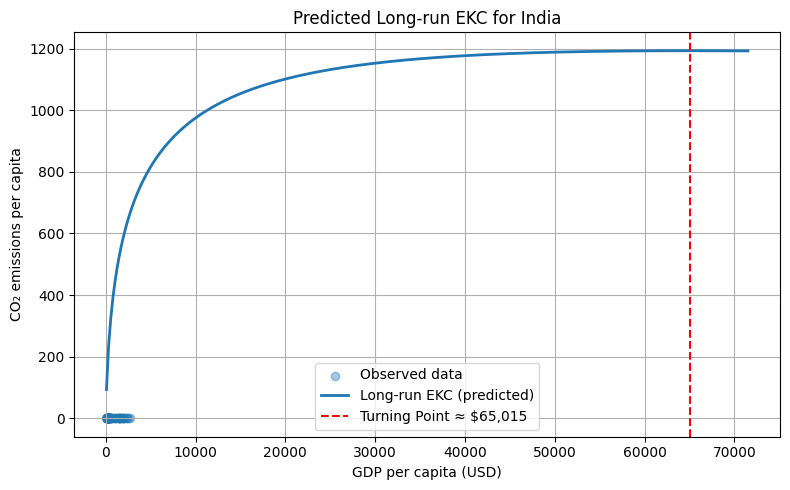

In [23]:
# EKC prediction to turing point:


# Create extended GDP range (prediction space)
gdp_min = ekc_pc_df['GDP_pc'].min()
gdp_max = turning_point * 1.1  # slightly beyond turning point

gdp_pc_pred = np.linspace(gdp_min, gdp_max, 300)
ln_gdp_pc_pred = np.log(gdp_pc_pred)

# Long-run EKC prediction
ln_co2_pred = (
    beta_gdp_lr * ln_gdp_pc_pred +
    beta_gdp2_lr * (ln_gdp_pc_pred ** 2)
)

co2_pred = np.exp(ln_co2_pred)

# Plot
plt.figure(figsize=(8, 5))

# Observed data (optional but recommended)
plt.scatter(
    ekc_pc_df['GDP_pc'],
    ekc_pc_df['CO2_pc'],
    alpha=0.4,
    label='Observed data'
)

# Long-run EKC prediction
plt.plot(
    gdp_pc_pred,
    co2_pred,
    linewidth=2,
    label='Long-run EKC (predicted)'
)

# Turning point
plt.axvline(
    x=turning_point,
    color='red',
    linestyle='--',
    label=f'Turning Point ≈ ${turning_point:,.0f}'
)

plt.xlabel('GDP per capita (USD)')
plt.ylabel('CO₂ emissions per capita')
plt.title('Predicted Long-run EKC for India')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


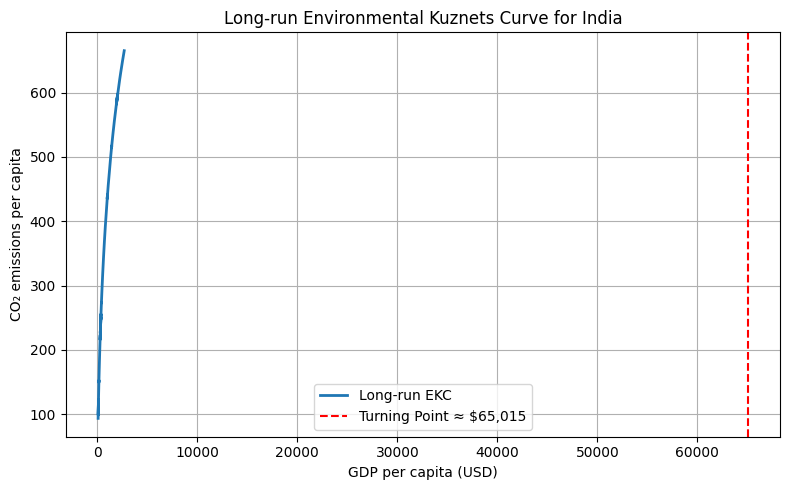

In [22]:
# ploting graph for long term using ARDL results


# Use observed GDP per capita range
gdp_pc = ekc_pc_df['GDP_pc']
ln_gdp_pc = np.log(gdp_pc)

# Long-run EKC fitted values
ln_co2_fitted = (
    beta_gdp_lr * ln_gdp_pc +
    beta_gdp2_lr * (ln_gdp_pc ** 2)
)

# Convert back to levels
co2_fitted = np.exp(ln_co2_fitted)

# Turning point (already computed)
turning_point = 65015.17

# Plot
plt.figure(figsize=(8, 5))
plt.plot(gdp_pc, co2_fitted, label='Long-run EKC', linewidth=2)

plt.axvline(
    x=turning_point,
    color='red',
    linestyle='--',
    label=f'Turning Point ≈ ${turning_point:,.0f}'
)

plt.xlabel('GDP per capita (USD)')
plt.ylabel('CO₂ emissions per capita')
plt.title('Long-run Environmental Kuznets Curve for India')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
